# Plot model performance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wmpgnn.configs.config_loader import ConfigLoader
#from wmpgnn.model.model_loader import ModelLoader

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


In [6]:
# Define the config files to compare
configs_to_compare = {
    "mlp_hom50": "mp_gnn_run3.yaml",
    #"mlp_hom100": "mp_gnn_run3_90k.yaml",
    #"mlp_het": "heteromp_gnn_run3.yaml",
}

# Load the config files
config_loader,datasets = {},{}
models = {}
for label, yml in configs_to_compare.items():
    config_loader[label] = ConfigLoader(f"config_files/{yml}", environment_prefix="DL")
    flatten_config = flatten_dict(config_loader[label].config)
    model_file = config_loader[label].get("training.model_file")
    csv_file = model_file.format(**flatten_config).replace(".pt",".csv")
    datasets[label] = pd.read_csv(csv_file)
    #models[label] = ModelLoader(config_loader).get_model()

## loss

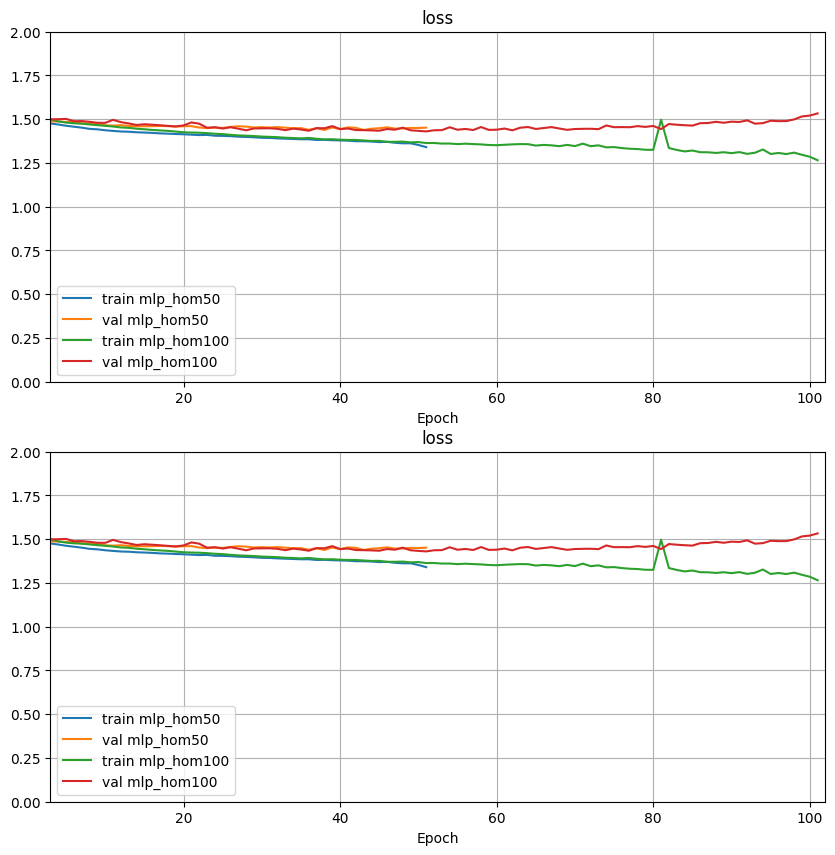

In [12]:
features = ['loss','loss']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for i, feature in enumerate(features):
    for label in configs_to_compare.keys():
        axs[i].plot(datasets[label][f"train_{feature}"], label=f"train {label}")
        axs[i].plot(datasets[label][f"val_{feature}"], label=f"val {label}")
    axs[i].set_xlabel('Epoch')
    axs[i].grid()
    axs[i].set_xlim(3, datasets[label].shape[0])
    axs[i].set_ylim(0, 2)
    axs[i].set_title(feature)
    axs[i].legend()

## metrics

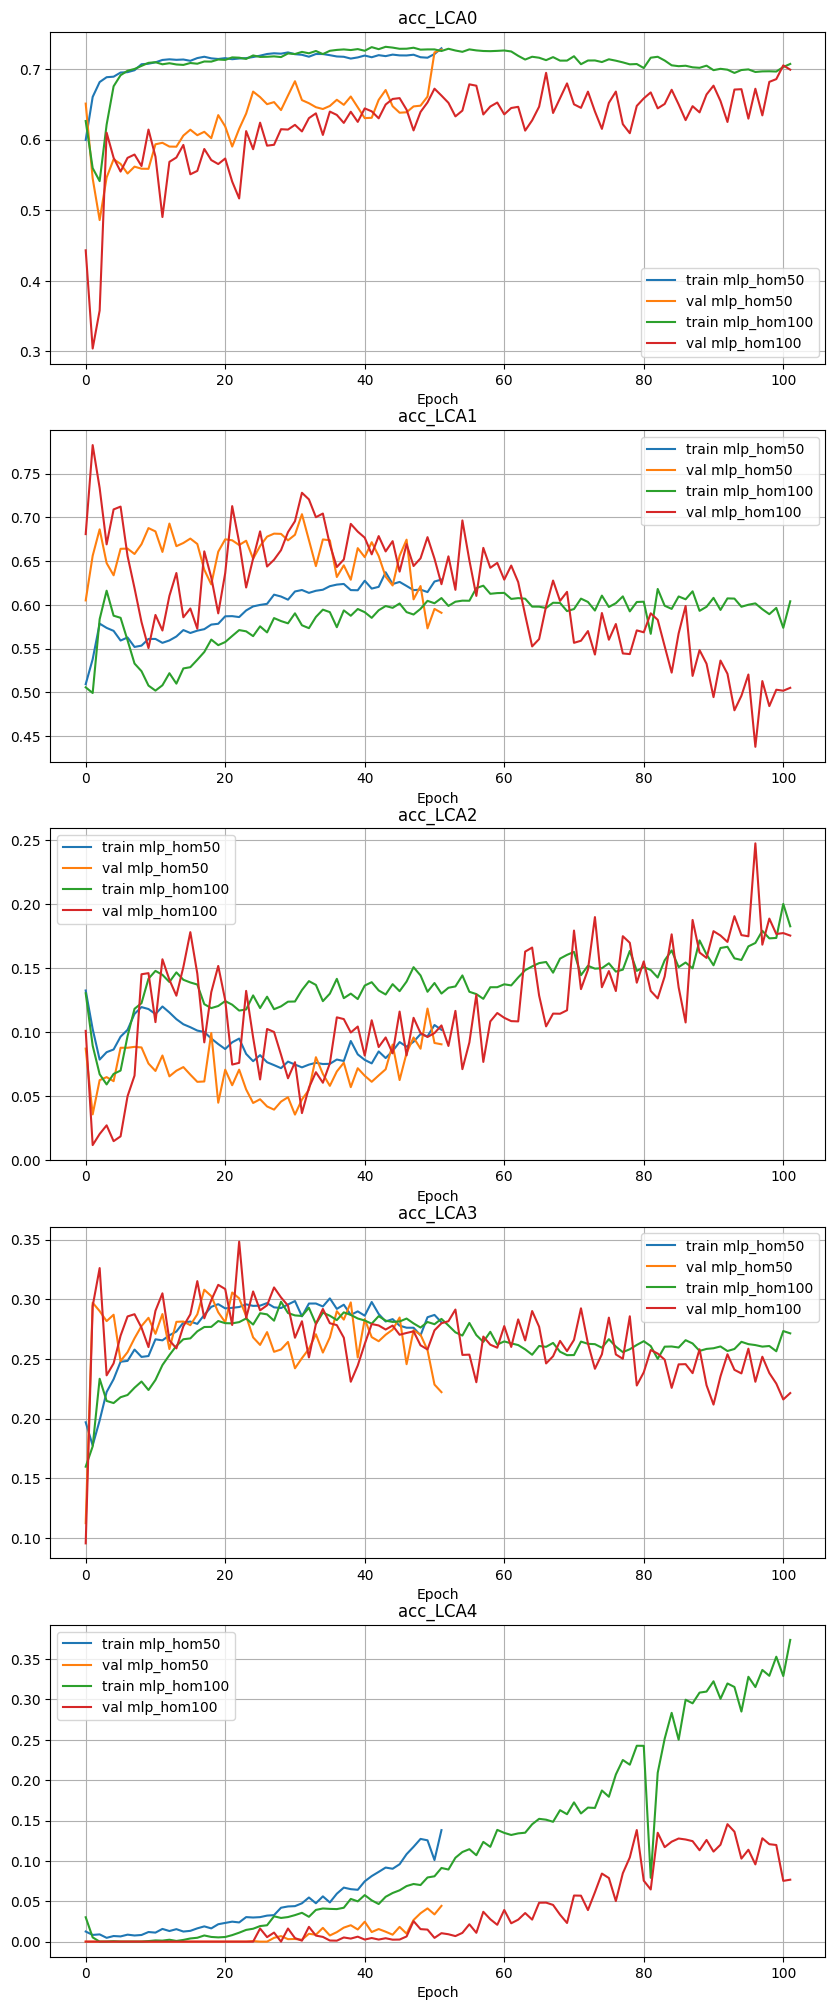

In [11]:
features = ['acc_LCA0', 'acc_LCA1', 'acc_LCA2', 'acc_LCA3', 'acc_LCA4']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for i, feature in enumerate(features):
    for label in configs_to_compare.keys():
        axs[i].plot(datasets[label][f"train_{feature}"], label=f"train {label}")
        axs[i].plot(datasets[label][f"val_{feature}"], label=f"val {label}")
    axs[i].set_xlabel('Epoch')
    axs[i].grid()
    axs[i].set_title(feature)
    axs[i].legend()

## Heterogeneous model

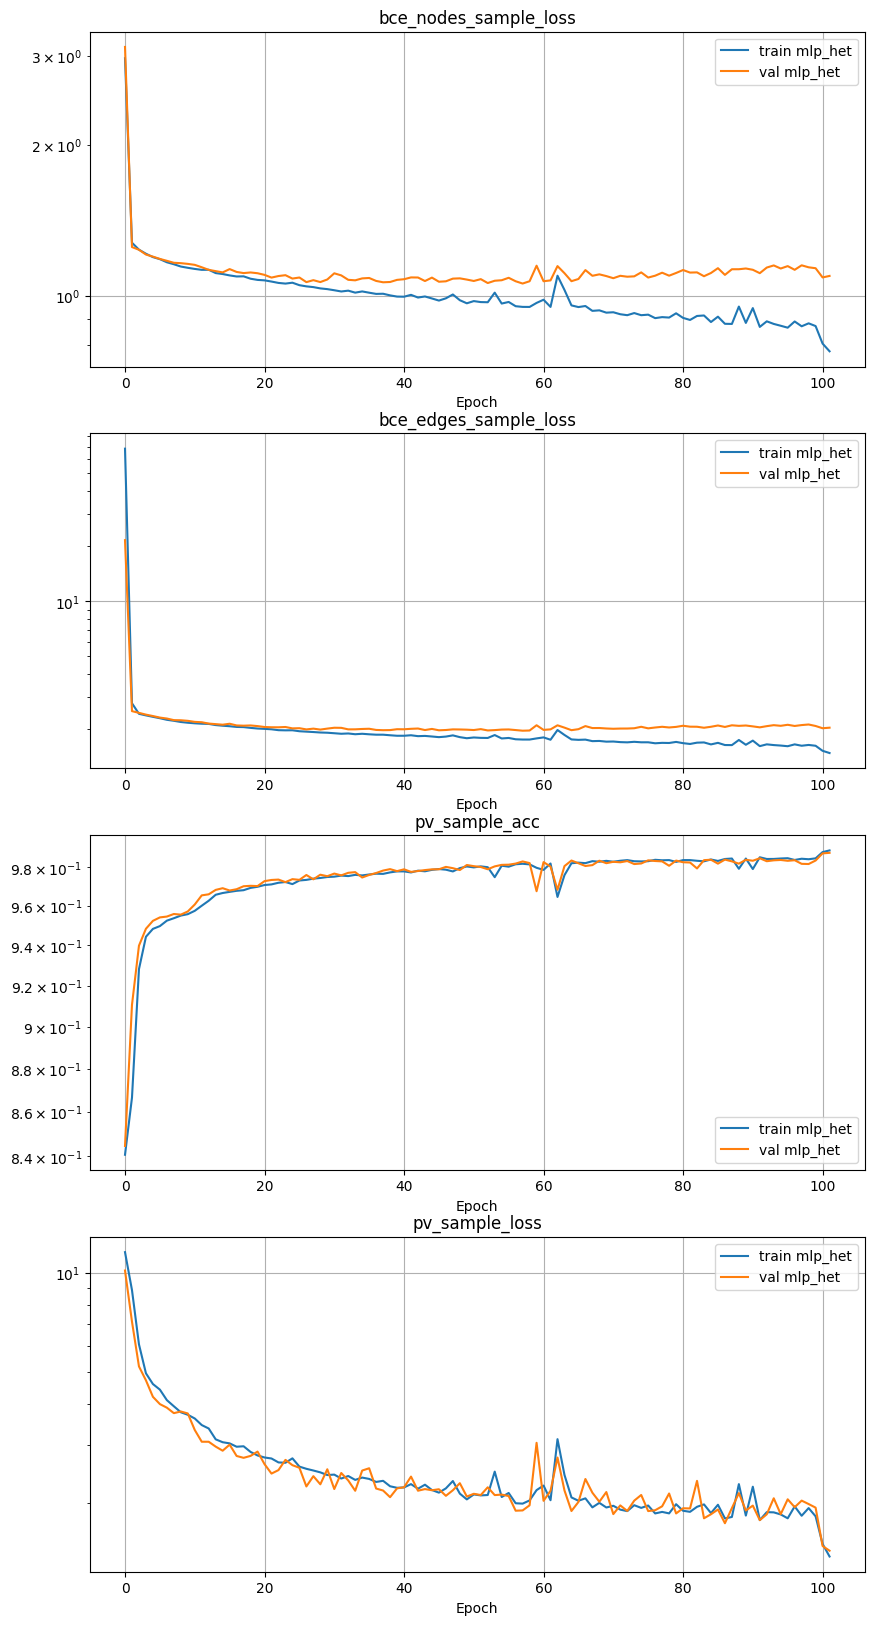

In [21]:
features = ['bce_nodes_sample_loss',
       'bce_edges_sample_loss', 'pv_sample_acc', 'pv_sample_loss']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for i, feature in enumerate(features):
    for sample in ['train','val']:
        axs[i].plot(datasets["mlp_het"][feature.replace("sample",sample)], label=f"{sample} mlp_het")
    axs[i].set_xlabel('Epoch')
    axs[i].grid()
    axs[i].set_yscale('log')
    axs[i].set_title(feature)
    axs[i].legend()